## Imports

In [2]:
import copy
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "/Users/eirikhoyheim/local_files/master/ISLBBNN/islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

# Problem description

We will work with the __abalone__ dataset, where we wan to predict the number of rings in abalones, which should correspond to the age. 

# Batch size and parameters

In [3]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
lr = config['lr']
class_problem = config["class_problem"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




#---------DATA------------
df = pd.read_csv("abalone.csv")
df = pd.get_dummies(df, drop_first=True)*1
#df = df.drop(["Sex"])
variable_names = list(df.loc[:,df.columns != "Rings"].columns)
X_original = df.loc[:,df.columns != "Rings"].values
y_original = df.loc[:,df.columns == "Rings"].values.T[0]
n, p = X_original.shape  # need this to get p 

print(n,p)

# Define BATCH sizes
BATCH_SIZE = int((n*0.8)/5)
TEST_BATCH_SIZE = int(n*0.10) 
VAL_BATCH_SIZE = int(n*0.10)

TRAIN_SIZE = int((n*0.80)/5)
TEST_SIZE = int(n*0.10)
VAL_SIZE = int(n*0.10)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

4177 9


# Sigmoid based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

## Train, validate, and test network

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem).to(DEVICE)
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_sigmoid", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

<img src="path_graphs/lrt/prob/test0_sigmoid.png" />

After training:

* 16 weights used in median model $\rightarrow$ density of 2\% compared to initialized model (789 weigths) 
* RMSE of 2.11 for both median and full model

## Attain weigth graph

In [5]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_sigmoid", show=True)

# ReLU based network

## Seperate a test set for later

In [3]:
# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    copy.deepcopy(X_original), copy.deepcopy(y_original), test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

<img src="path_graphs/lrt/prob/test0_relu.png" />

After training:

* 43 weights used in median model $\rightarrow$ density of 0.1\% compared to initialized model (43'809 weigths) 
* RMSE of 2.09 for median model
* RMSE of 13.61 for full model

## Weight graph

In [5]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu", show=True)

 <img src="path_graphs/lrt/weight/temp_sigmoid.png" />

## Local contribution

### Empirical approach

True val: 10.0


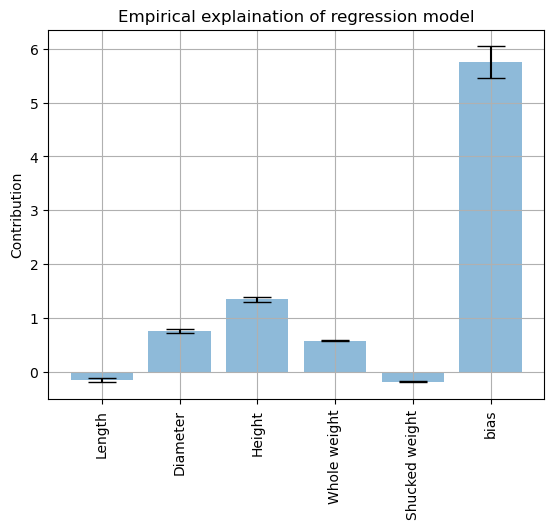

In [94]:
explain_this = train_dat[3001,:-1].reshape(-1, p)
print(f"True val: {train_dat[3001,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=10_000,class_names=["regression model"], variable_names=variable_names)

True val: 13.0


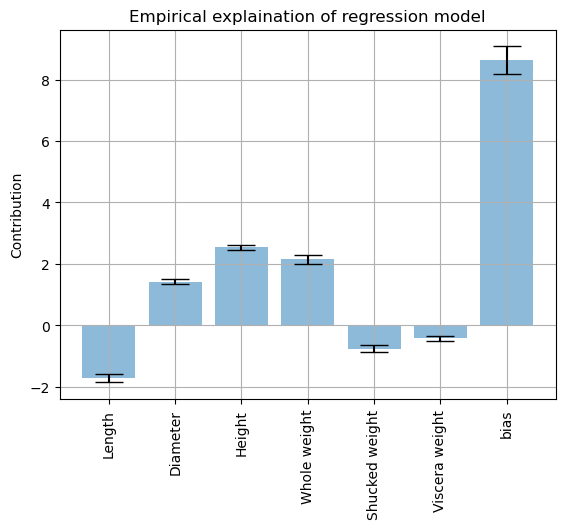

In [100]:
explain_this = train_dat[3005,:-1].reshape(-1, p)
print(f"True val: {train_dat[3005,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=10_000,class_names=["regression model"], variable_names=variable_names)

True val: 8.0


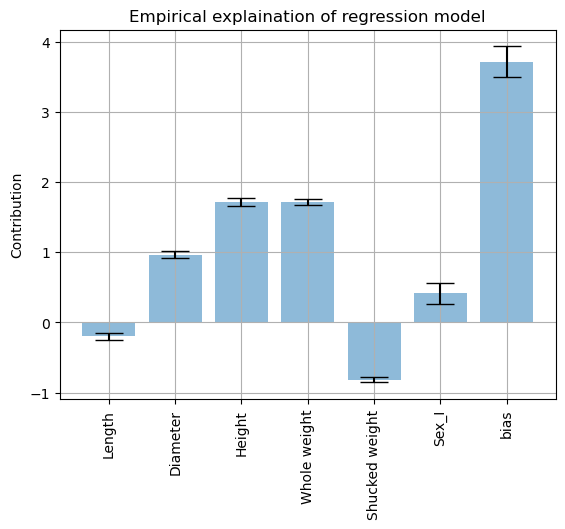

In [107]:
explain_this = train_dat[3300,:-1].reshape(-1, p)
print(f"True val: {train_dat[3300,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=10_000,class_names=["regression model"], variable_names=variable_names)

In [95]:
net.eval()
preds = []
for _ in range(10_000):
    preds.append(net.forward(explain_this, ensemble=False, sample=True)[0])

torch.mean(torch.tensor(preds)), torch.std(torch.tensor(preds))

(tensor(8.0770), tensor(0.1493))

### Distribution approach

In [78]:
net.forward(explain_this, ensemble=False, sample=False)

tensor([[7.8734]], grad_fn=<AddBackward0>)

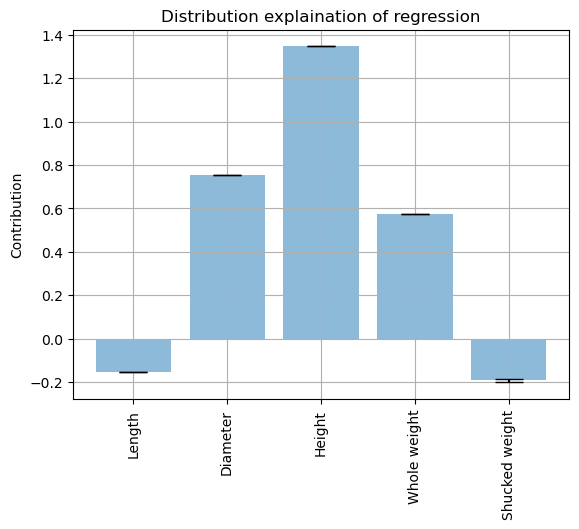

In [109]:
explain_this = train_dat[3001,:-1].reshape(-1, p)
pf.plot_local_contribution_dist(net, explain_this, sample=False, median=True, variable_names=variable_names, class_names=["regression"])

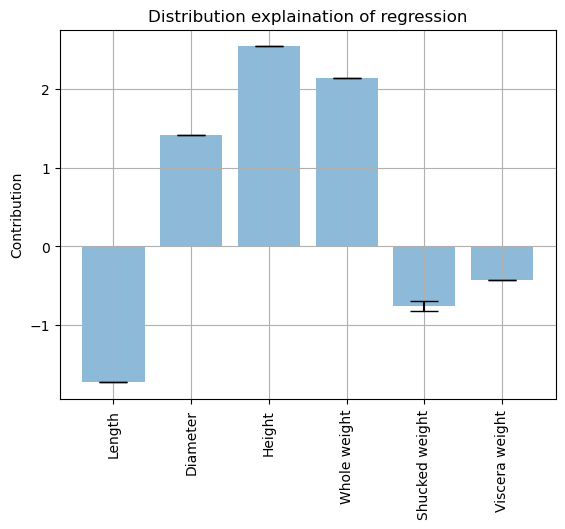

In [110]:
explain_this = train_dat[3005,:-1].reshape(-1, p)
pf.plot_local_contribution_dist(net, explain_this, sample=False, median=True, variable_names=variable_names, class_names=["regression"])

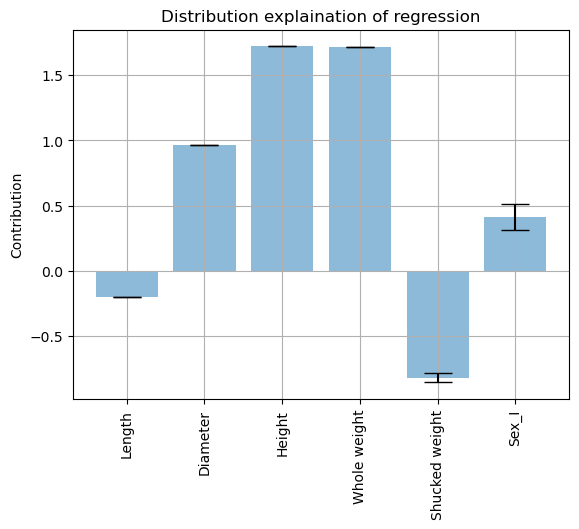

In [111]:
explain_this = train_dat[3300,:-1].reshape(-1, p)
pf.plot_local_contribution_dist(net, explain_this, sample=False, median=True, variable_names=variable_names, class_names=["regression"])

__NOTE__: The distribution approach usually underestimate the variance as it assumes constant active paths.